In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import itertools
from collections import Counter

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

In [5]:
from scipy import stats
from scipy.stats import norm, gamma, linregress, skew
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering 
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
import pymc3 as pm

In [6]:
def dump_pickle(file, filename):
    outfile = open(filename, 'wb')
    pickle.dump(file, outfile)
    outfile.close()

def load_pickle(filename):
    infile = open(filename, 'rb')
    file = pickle.load(infile)
    infile.close()
    return file

In [7]:
sns.set()

## Data Prep

Read cluster data

In [8]:
df = pd.read_csv('nba_cleaned.csv')
df.shape

(1774, 116)

In [9]:
label_cols = ['Player', 'Season', 'Team', 'player_cluster']
label_df = df[label_cols].rename(columns={'Season': 'season',
                                          'Team': 'team'})
label_df.head()

,Player,season,team,player_cluster
0,Marc Gasol,2017,Memphis Grizzlies,6
1,Tyreke Evans,2017,Memphis Grizzlies,2
2,Dillon Brooks,2017,Memphis Grizzlies,1
3,Jarell Martin,2017,Memphis Grizzlies,3
4,Mario Chalmers,2017,Memphis Grizzlies,1


Read lineup data by CleaningTheGlass

In [10]:
lineup_df = pd.read_csv('ctg_nba_lineup_stats.csv')
lineup_df = lineup_df[lineup_df['season'] != 2016].reset_index(drop=True)
lineup_df.shape

(67655, 30)

In [11]:
lineup_cols = ['PG', 'SG', 'SF', 'PF', 'C', 'season', 'team', 'Poss'] + \
              [col for col in lineup_df.columns if 'off_' in col]
lineup_df = lineup_df[lineup_cols]
lineup_df.head()

,PG,SG,SF,PF,C,season,team,Poss,off_Pts/Poss_rank,off_Pts/Poss,off_eFG%_rank,off_eFG%,off_TOV%_rank,off_TOV%,off_OREB%_rank,off_OREB%,off_FTr_rank,off_FTr
0,Dennis Schroder,Kent Bazemore,Taurean Prince,Ersan Ilyasova,Miles Plumlee,2017,Atlanta Hawks,733,18.0,99.9,41.0,51.5%,12.0,17.7%,59.0,25.9%,37.0,15.0
1,Dennis Schroder,Kent Bazemore,Taurean Prince,John Collins,Dewayne Dedmon,2017,Atlanta Hawks,245,66.0,112.7,81.0,57.9%,15.0,17.1%,37.0,23.1%,41.0,15.7
2,Dennis Schroder,Kent Bazemore,Taurean Prince,Ersan Ilyasova,Dewayne Dedmon,2017,Atlanta Hawks,193,22.0,101.0,18.0,48.8%,78.0,12.4%,22.0,20.4%,73.0,22.1
3,Dennis Schroder,Kent Bazemore,Taurean Prince,Luke Babbitt,Dewayne Dedmon,2017,Atlanta Hawks,142,62.0,112.0,91.0,59.7%,7.0,19.0%,44.0,23.8%,5.0,8.9
4,Isaiah Taylor,Taurean Prince,Damion Lee,John Collins,Dewayne Dedmon,2017,Atlanta Hawks,140,36.0,105.7,41.0,51.5%,62.0,13.6%,36.0,23.1%,4.0,8.3


Read kmeans models

In [12]:
nba_clustering_models_km = load_pickle('nba_clustering_models_km')
pre_pca_pipe = nba_clustering_models_km['pre_pca_pipe']
pca = nba_clustering_models_km['pca']
pre_cluster_scaler = nba_clustering_models_km['pre_cluster_scaler']
cluster_map_km_to_sc = nba_clustering_models_km['cluster_map_to_spectral_clustering']
km = nba_clustering_models_km['km']

In [13]:
cluster_dict_detail = {2: 'Ballhandler (Iso+PnR)', 1: 'Ballhandler (PnR)',
                       6: 'Big (Post Up+Roll)', 5: 'Big (Roll+Cut)',
                       0: 'Wing (Off Screen)', 4: 'Wing (Hand Off)', 
                       3: 'Wing (Spot Up+Transition)'}

In [14]:
# temp = label_df.copy()
# temp['cluster_description'] = temp['player_cluster'].map(cluster_dict_detail)
# temp[(temp['season'] == 2021) & 
#      (temp['team'] == 'Miami Heat')]

Read Synergy data

In [15]:
s_df = pd.read_csv('nba_offense.csv')
s_df = s_df[s_df['Season'] != 2016]
s_df['Player'] = s_df['Player'].apply(lambda x: ' '.join(x.split(' ')[1:]))
s_df['Overall_Poss'] = s_df['Overall_Poss'] - s_df['Miscellaneous_Poss']

In [16]:
poss_weights_cols = ['Spot Up_Poss%', 'P&R Ball Handler_Poss%', 
                     'Hand Off_Poss%', 'Off Screen_Poss%',
                     'Cut_Poss%', 'Offensive Rebounds (put backs)_Poss%',
                     'P&R Roll Man_Poss%', 'Isolation_Poss%', 
                     'Post-Up_Poss%', 'Transition_Poss%'] 

In [17]:
for col in poss_weights_cols:
    s_df[col] = s_df[col.replace('%', '')] / s_df['Overall_Poss']
    s_df[col] = s_df[col].fillna(0)

Synergy functions

In [18]:
def player_lookup(player, df, season=2021, if_ppp_n_rank=False):
    pdf = df[(df['Player'] == player) & (df['Season'] == season)]
    for idx in pdf.index:
        print(player, pdf.loc[idx]['Team'])
        print('-')
        for col in df.columns:
            if 'Poss%' in col and 'Miscellaneous' not in col:
                print(col, f'{pdf.loc[idx][col]:.2%}')
                if if_ppp_n_rank:
                    ppp_col = col.replace('Poss%', 'PPP')
                    print(ppp_col, f'{pdf.loc[idx][ppp_col]:.3f}')
                    rank_col = col.replace('Poss%', 'Rank')
                    print(rank_col, f'{pdf.loc[idx][rank_col]}')
                print('-')

## Feature Engineering

### Get League/Team Offensive Rating for each Season

In [19]:
tm_lineup_df = lineup_df.copy()
tm_lineup_df['off_Pts'] = lineup_df['off_Pts/Poss'] * lineup_df['Poss']

In [20]:
season_off_ratings = tm_lineup_df.groupby('season')[['off_Pts', 'Poss']].sum()
season_off_ratings['off_Pts/Poss'] = season_off_ratings['off_Pts'] / \
                                     season_off_ratings['Poss']
season_off_ratings[['off_Pts/Poss']].reset_index()

,season,off_Pts/Poss
0,2017,108.329988
1,2018,110.480204
2,2019,110.793898
3,2020,112.795304
4,2021,112.255389


In [21]:
tm_off_ratings = tm_lineup_df.groupby(['team', 'season'])[['off_Pts', 'Poss']].sum()
tm_off_ratings['off_Pts/Poss'] = tm_off_ratings['off_Pts'] / tm_off_ratings['Poss']
tm_off_ratings = tm_off_ratings[['off_Pts/Poss']].reset_index()\
                                                 .rename(columns={'off_Pts/Poss': 'tm_off_Pts/Poss'})
tm_off_ratings

,team,season,tm_off_Pts/Poss
0,Atlanta Hawks,2017,104.452049
1,Atlanta Hawks,2018,107.673913
2,Atlanta Hawks,2019,107.546858
3,Atlanta Hawks,2020,115.375155
4,Atlanta Hawks,2021,116.125381
...,...,...,...
145,Washington Wizards,2017,108.547292
146,Washington Wizards,2018,110.997148
147,Washington Wizards,2019,110.553583
148,Washington Wizards,2020,111.587056


### Merge

### Step 1: Find out who did not have a cluster tag

In [22]:
synergy_name_dict = {'kevinporterjr': 'kevinporter',
                     'patrickbeverly': 'patrickbeverley',
                     'terryrozieriii': 'terryrozier',
                     'kellyoubrejr': 'kellyoubre',
                     'lonniewalkeriv': 'lonniewalker',
                     'ottoporterjr': 'ottoporter',
                     'robertwilliamsiii': 'robertwilliams',
                     'wendellcarterjr': 'wendellcarter',
                     'alfarouqaminu': 'al-farouqaminu',
                     'jarenjacksonjr': 'jarenjackson',
                     'marvinbagleyiii': 'marvinbagley',
                     'marcusmorrissr': 'marcusmorris',
                     'wesleyiwundu': 'wesiwundu',
                     'troybrownjr': 'troybrown',
                     'larrynance': 'larrynancejr',
                     'michaelporterjr': 'michaelporter',
                     'kevinknoxii': 'kevinknox',
                     'jamesennisiii': 'jamesennis',
                     'danilogalinari': 'danilogallinari',
                     'danuelhousejr': 'danuelhouse',
                     'svimykhailiuk': 'sviatoslavmykhailiuk',
                     'timothéluwawu-cabarrot': 'timotheluwawu-cabarrot',
                     'duanewashingtonjr': 'duanewashington',
                     'juanchohernangomez': 'juanhernangomez',
                     'harrygilesiii': 'harrygiles',
                     'malcomdelaney': 'malcolmdelaney'}

In [23]:
label_df['player_alt'] = label_df['Player'].apply(lambda x: x.replace(' ', '').lower())\
                                           .apply(lambda x: x.replace("'", ''))\
                                           .apply(lambda x: x.replace('.', ''))\
                                           .apply(lambda x: synergy_name_dict[x] 
                                                  if x in synergy_name_dict.keys()
                                                  else x)
label_df = label_df.drop('Player', axis=1)
label_df.head()

,season,team,player_cluster,player_alt
0,2017,Memphis Grizzlies,6,marcgasol
1,2017,Memphis Grizzlies,2,tyrekeevans
2,2017,Memphis Grizzlies,1,dillonbrooks
3,2017,Memphis Grizzlies,3,jarellmartin
4,2017,Memphis Grizzlies,1,mariochalmers


Adjust name in the lineup data.

In [24]:
positions = ['PG', 'SG', 'SF', 'PF', 'C']
for pos in positions:
    lineup_df[f'{pos}_alt'] = lineup_df[pos].apply(lambda x: x.replace(' ', ''))\
                                            .apply(lambda x: x.replace("'", ''))\
                                            .apply(lambda x: x.replace('.', ''))\
                                            .apply(lambda x: x.lower())
lineup_df.head()

,PG,SG,SF,PF,C,season,team,Poss,off_Pts/Poss_rank,off_Pts/Poss,off_eFG%_rank,off_eFG%,off_TOV%_rank,off_TOV%,off_OREB%_rank,off_OREB%,off_FTr_rank,off_FTr,PG_alt,SG_alt,SF_alt,PF_alt,C_alt
0,Dennis Schroder,Kent Bazemore,Taurean Prince,Ersan Ilyasova,Miles Plumlee,2017,Atlanta Hawks,733,18.0,99.9,41.0,51.5%,12.0,17.7%,59.0,25.9%,37.0,15.0,dennisschroder,kentbazemore,taureanprince,ersanilyasova,milesplumlee
1,Dennis Schroder,Kent Bazemore,Taurean Prince,John Collins,Dewayne Dedmon,2017,Atlanta Hawks,245,66.0,112.7,81.0,57.9%,15.0,17.1%,37.0,23.1%,41.0,15.7,dennisschroder,kentbazemore,taureanprince,johncollins,dewaynededmon
2,Dennis Schroder,Kent Bazemore,Taurean Prince,Ersan Ilyasova,Dewayne Dedmon,2017,Atlanta Hawks,193,22.0,101.0,18.0,48.8%,78.0,12.4%,22.0,20.4%,73.0,22.1,dennisschroder,kentbazemore,taureanprince,ersanilyasova,dewaynededmon
3,Dennis Schroder,Kent Bazemore,Taurean Prince,Luke Babbitt,Dewayne Dedmon,2017,Atlanta Hawks,142,62.0,112.0,91.0,59.7%,7.0,19.0%,44.0,23.8%,5.0,8.9,dennisschroder,kentbazemore,taureanprince,lukebabbitt,dewaynededmon
4,Isaiah Taylor,Taurean Prince,Damion Lee,John Collins,Dewayne Dedmon,2017,Atlanta Hawks,140,36.0,105.7,41.0,51.5%,62.0,13.6%,36.0,23.1%,4.0,8.3,isaiahtaylor,taureanprince,damionlee,johncollins,dewaynededmon


First attempt to assign cluster label to lineup data.  
The expectation is, there will be some `nan` (missing players) after the merge.

In [25]:
temp = lineup_df.copy()
for pos in positions:
    temp = temp.merge(label_df.rename(columns={'player_alt': f'{pos}_alt'}), 
                      how='left')\
               .rename(columns={'player_cluster': f'{pos}_cluster'})

Find missing players that appear in lineups that logged 100 possessions.

In [26]:
rows_missing = pd.concat([temp[(temp[f'{pos}_cluster'].isna()) & 
                               (temp['Poss'] >= 100)]
                          for pos in positions])\
                 .drop_duplicates()\
                 .sort_values('Poss', ascending=False)

missing_players_data = []
for idx in rows_missing.index:
    row = rows_missing.loc[idx]
    for pos in positions:
        if row[f'{pos}_cluster'] not in [0, 1, 2, 3, 4, 5, 6]:
            missing_players_data.append([row['season'], 
                                         row['team'],
                                         row[pos],
                                         row[f'{pos}_alt']])

missing_players_df = pd.DataFrame(missing_players_data,
                                  columns=['season', 'team', 'player', 'player_alt'])\
                       .drop_duplicates().reset_index(drop=True)
missing_players_df

,season,team,player,player_alt
0,2017,Oklahoma City Thunder,Andre Roberson,andreroberson
1,2017,Oklahoma City Thunder,Corey Brewer,coreybrewer
2,2020,Denver Nuggets,Gary Harris,garyharris
3,2017,Oklahoma City Thunder,Terrance Ferguson,terranceferguson
4,2019,Portland Trail Blazers,Trevor Ariza,trevorariza
...,...,...,...,...
174,2020,Minnesota Timberwolves,Ed Davis,eddavis
175,2020,New York Knicks,Austin Rivers,austinrivers
176,2021,Brooklyn Nets,Day'Ron Sharpe,dayronsharpe
177,2019,Orlando Magic,Al-Farouq Aminu,al-farouqaminu


Find out how many players are missing.

In [27]:
missing_players_df.shape

(179, 4)

In [28]:
s_df['player_alt'] = s_df['Player'].apply(lambda x: x.replace(' ', '').lower())\
                                   .apply(lambda x: x.replace("'", ''))\
                                   .apply(lambda x: x.replace('.', ''))\
                                   .apply(lambda x: synergy_name_dict[x] 
                                          if x in synergy_name_dict.keys()
                                          else x)

Merge Synergy records to missing players.

In [29]:
missing_players_df = missing_players_df.merge(s_df,
                                              left_on=['team', 'season', 'player_alt'],
                                              right_on=['Team', 'Season', 'player_alt'],
                                              how='left')

Make sure that we find all the Synergy data for the missing players.

In [30]:
missing_players_df[missing_players_df['Overall_Poss'].isna()]\
[['Player', 'Team', 'Season', 'Overall_Poss']]

,Player,Team,Season,Overall_Poss


### Step 2: Create cluster tags for those who don't have one

Assign player clusters using previously-trained model.

In [31]:
X = missing_players_df[poss_weights_cols].copy()
X_transformed = pre_cluster_scaler.transform(pca.transform(pre_pca_pipe.transform(X)))
missing_players_df['player_cluster'] = km.predict(X_transformed)
missing_players_df['player_cluster'] = missing_players_df['player_cluster'].map(cluster_map_km_to_sc)

Check players got assigned to cluster 2 or 6, which are relatively primary role.

In [32]:
cluster_dict_detail

{2: 'Ballhandler (Iso+PnR)',
 1: 'Ballhandler (PnR)',
 6: 'Big (Post Up+Roll)',
 5: 'Big (Roll+Cut)',
 0: 'Wing (Off Screen)',
 4: 'Wing (Hand Off)',
 3: 'Wing (Spot Up+Transition)'}

In [33]:
missing_players_df[missing_players_df['Overall_Poss'] < 100]\
.groupby('player_cluster')['player'].count()

player_cluster
0     4
1     4
2     1
3     8
4     3
5    11
6     4
Name: player, dtype: int64

In [34]:
missing_players_df[(missing_players_df['Overall_Poss'] < 100) &
                   (missing_players_df['player_cluster'].isin([2, 6]))]\
[['Player', 'Team', 'Season', 'Overall_Poss', 'player_cluster']].sort_values('Overall_Poss')

,Player,Team,Season,Overall_Poss,player_cluster
153,Dakari Johnson,Oklahoma City Thunder,2017,47.0,6
59,Iman Shumpert,Cleveland Cavaliers,2017,75.0,2
91,Frank Kaminsky,Phoenix Suns,2021,77.0,6
53,Zach Collins,Portland Trail Blazers,2019,79.0,6
19,Dwight Howard,Washington Wizards,2018,95.0,6


### Step 3: Complete assigning cluster labels in lineup data

Add cluster labels of missing players to the original label data.

In [35]:
label_df_adj = pd.concat([label_df,
                          missing_players_df[['season', 'team', 
                                              'player_cluster', 'player_alt']]])\
                 .reset_index(drop=True)
label_df_adj.shape

(1953, 4)

Assign labels.

In [36]:
for pos in positions:
    lineup_df = lineup_df.merge(label_df_adj.rename(columns={'player_alt': f'{pos}_alt'}),
                                how='left')\
                         .rename(columns={'player_cluster': f'{pos}_cluster'})

Check if there are missing records with no cluster labels.

In [37]:
pd.concat([lineup_df[(lineup_df[f'{pos}_cluster'].isna()) & 
                     (lineup_df['Poss'] >= 100)]
           for pos in positions])\
  .drop_duplicates()\
  .sort_values('Poss', ascending=False)

,PG,SG,SF,PF,C,season,team,Poss,off_Pts/Poss_rank,off_Pts/Poss,off_eFG%_rank,off_eFG%,off_TOV%_rank,off_TOV%,off_OREB%_rank,off_OREB%,off_FTr_rank,off_FTr,PG_alt,SG_alt,SF_alt,PF_alt,C_alt,PG_cluster,SG_cluster,SF_cluster,PF_cluster,C_cluster


### Step 4: Create cluster embeddings

In [38]:
lineup_df_100 = lineup_df[lineup_df['Poss'] >= 100].reset_index(drop=True)

In [39]:
lineup_df_100['lineup_clusters'] = lineup_df_100.apply(lambda x: [x[f'{pos}_cluster'] 
                                                                  for pos in positions], 
                                                       axis=1)

In [40]:
for i in range(7):
    lineup_df_100[i] = lineup_df_100['lineup_clusters'].apply(lambda x: x.count(i))

In [41]:
lineup_df_100['lineup_embedding'] = lineup_df_100.apply(lambda x: '-'.join([str(x[i]) 
                                                                            for i in range(7)]), 
                                                        axis=1)

### Step 5: Compute 'adjusted offensive ratings'

Inspired by 'NBA Lineup Analysis on Clustered Player Tendencies: A new approach to the positions of basketball & modeling lineup efficiency', the adjusted offensive ratings for lineups that logged under 300 possession are computed like the following:  

$Adj. Off Rating = (\frac{Poss}{300}) * Off Rating + (\frac{300-Poss}{300}) * Tm Off Rating$

In [42]:
lineup_df_100.shape, lineup_df_100[lineup_df_100['Poss'] >= 300].shape

((1521, 37), (302, 37))

In [43]:
lineup_df_100 = lineup_df_100.merge(tm_off_ratings, how='left')

In [44]:
lineup_df_100['adj_off_Pts/Poss'] = lineup_df_100['off_Pts/Poss']
cond = lineup_df_100['Poss'] < 300
lineup_df_100.loc[cond, 'adj_off_Pts/Poss'] = lineup_df_100.loc[cond, 'off_Pts/Poss'] * \
                                              (lineup_df_100.loc[cond, 'Poss'] / 300) + \
                                              lineup_df_100.loc[cond, 'tm_off_Pts/Poss'] * \
                                              ((300 - lineup_df_100.loc[cond, 'Poss']) / 300)

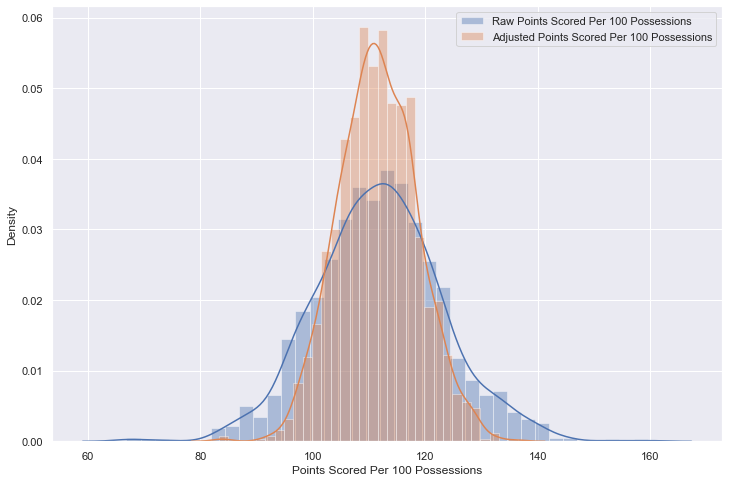

In [46]:
figsize(12, 8)
sns.distplot(lineup_df_100['off_Pts/Poss'], 
             label='Raw Points Scored Per 100 Possessions')
sns.distplot(lineup_df_100['adj_off_Pts/Poss'], 
             label='Adjusted Points Scored Per 100 Possessions')
plt.xlabel('Points Scored Per 100 Possessions')
plt.legend()

In [47]:
league_avg = season_off_ratings[['off_Pts/Poss']].reset_index()\
                                                 .rename(columns={'off_Pts/Poss': 
                                                                  'league_avg_off_Pts/Poss'})
lineup_df_100 = lineup_df_100.merge(league_avg, how='left')
lineup_df_100['diff_to_league_avg'] = lineup_df_100['off_Pts/Poss'] - \
                                      lineup_df_100['league_avg_off_Pts/Poss']
lineup_df_100['adj_diff_to_league_avg'] = lineup_df_100['adj_off_Pts/Poss'] - \
                                          lineup_df_100['league_avg_off_Pts/Poss']

## Exploratory Data Analysis

### Ticket 1: How many types of lineups?

In [48]:
lineup_df_100.groupby('lineup_embedding')[['lineup_clusters']].count().shape

(175, 1)

### Ticket 2: What are the top 10 most popular lineups?

In [49]:
cluster_dict_detail

{2: 'Ballhandler (Iso+PnR)',
 1: 'Ballhandler (PnR)',
 6: 'Big (Post Up+Roll)',
 5: 'Big (Roll+Cut)',
 0: 'Wing (Off Screen)',
 4: 'Wing (Hand Off)',
 3: 'Wing (Spot Up+Transition)'}

In [50]:
def lineup_embedding_to_detail(s, cluster_dict_detail=cluster_dict_detail):
    detail = []
    lineup = s.split('-')
    for i in range(7):
        n = int(lineup[i])
        if n != 0:
            detail.append(f'{n} {cluster_dict_detail[i]}')
    return ' | '.join(detail)

In [51]:
t_2 = lineup_df_100.groupby('lineup_embedding')[['lineup_clusters']]\
                   .count().reset_index()\
                   .rename(columns={'lineup_clusters': 'num_lineups'})
t_2['lineup_detail'] = t_2['lineup_embedding'].apply(lineup_embedding_to_detail)
t_2.sort_values('num_lineups', ascending=False).head(10)

,lineup_embedding,num_lineups,lineup_detail
81,0-2-1-1-0-1-0,57,2 Ballhandler (PnR) | 1 Ballhandler (Iso+PnR) | 1 Wing (Spot Up+Transition) | 1 Big (Roll+Cut)
132,1-1-1-1-0-1-0,54,1 Wing (Off Screen) | 1 Ballhandler (PnR) | 1 Ballhandler (Iso+PnR) | 1 Wing (Spot Up+Transition) | 1 Big (Roll+Cut)
52,0-1-1-2-0-0-1,51,1 Ballhandler (PnR) | 1 Ballhandler (Iso+PnR) | 2 Wing (Spot Up+Transition) | 1 Big (Post Up+Roll)
73,0-2-0-2-0-0-1,49,2 Ballhandler (PnR) | 2 Wing (Spot Up+Transition) | 1 Big (Post Up+Roll)
126,1-1-0-2-0-1-0,41,1 Wing (Off Screen) | 1 Ballhandler (PnR) | 2 Wing (Spot Up+Transition) | 1 Big (Roll+Cut)
74,0-2-0-2-0-1-0,39,2 Ballhandler (PnR) | 2 Wing (Spot Up+Transition) | 1 Big (Roll+Cut)
144,1-2-0-1-0-1-0,38,1 Wing (Off Screen) | 2 Ballhandler (PnR) | 1 Wing (Spot Up+Transition) | 1 Big (Roll+Cut)
156,2-0-1-1-0-1-0,32,2 Wing (Off Screen) | 1 Ballhandler (Iso+PnR) | 1 Wing (Spot Up+Transition) | 1 Big (Roll+Cut)
53,0-1-1-2-0-1-0,32,1 Ballhandler (PnR) | 1 Ballhandler (Iso+PnR) | 2 Wing (Spot Up+Transition) | 1 Big (Roll+Cut)
131,1-1-1-1-0-0-1,29,1 Wing (Off Screen) | 1 Ballhandler (PnR) | 1 Ballhandler (Iso+PnR) | 1 Wing (Spot Up+Transition) | 1 Big (Post Up+Roll)


In [52]:
lineup_df_100[lineup_df_100['lineup_embedding'] == '0-2-1-1-0-1-0'].head(1)

,PG,SG,SF,PF,C,season,team,Poss,off_Pts/Poss_rank,off_Pts/Poss,off_eFG%_rank,off_eFG%,off_TOV%_rank,off_TOV%,off_OREB%_rank,off_OREB%,off_FTr_rank,off_FTr,PG_alt,SG_alt,SF_alt,PF_alt,C_alt,PG_cluster,SG_cluster,SF_cluster,PF_cluster,C_cluster,lineup_clusters,0,1,2,3,4,5,6,lineup_embedding,tm_off_Pts/Poss,adj_off_Pts/Poss,league_avg_off_Pts/Poss,diff_to_league_avg,adj_diff_to_league_avg
72,Kemba Walker,Jaylen Brown,Gordon Hayward,Jayson Tatum,Daniel Theis,2019,Boston Celtics,543,69.0,116.6,79.0,58.1%,63.0,13.1%,36.0,22.9%,23.0,13.8,kembawalker,jaylenbrown,gordonhayward,jaysontatum,danieltheis,1.0,3.0,1.0,2.0,5.0,"[1.0, 3.0, 1.0, 2.0, 5.0]",0,2,1,1,0,1,0,0-2-1-1-0-1-0,113.556036,116.6,110.793898,5.806102,5.806102


In [53]:
t_2.shape, t_2[t_2['num_lineups'] >= 10].shape, t_2[t_2['num_lineups'] >= 30].shape

((175, 3), (47, 3), (9, 3))

Distributions of lineups with # >= 30

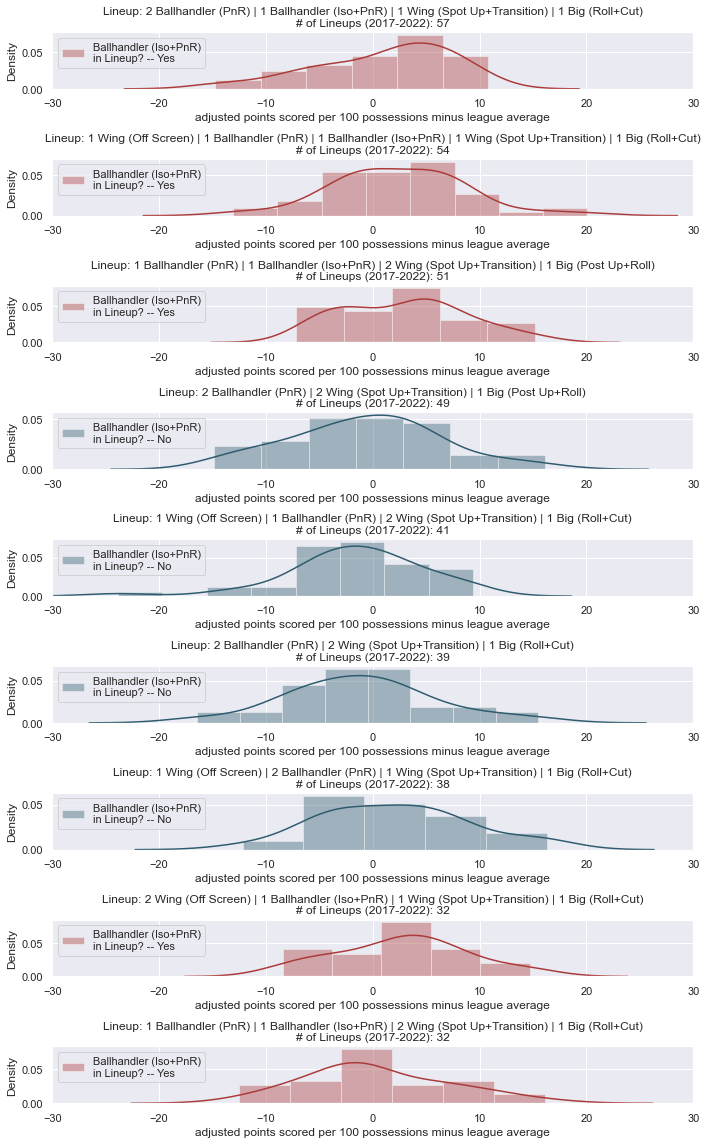

In [55]:
figsize(10, 16)

n = 9
temp = t_2.sort_values('num_lineups', ascending=False)\
          .head(n).values

for idx in range(n):
    le, num, ld = temp[idx]
    lineup_cond = lineup_df_100['lineup_embedding'] == le
    
    plt.subplot(n, 1, idx+1)
    title = f'Lineup: {ld}\n# of Lineups (2017-2022): {num}'
    plt.title(title)
    color = '#2E5C6E'
    label = 'Ballhandler (Iso+PnR)\nin Lineup? -- No'
    if 'Ballhandler (Iso+PnR)' in title:
        color = '#AB3B3A'
        label = label.replace('No', 'Yes')
    sns.distplot(lineup_df_100[lineup_cond]['adj_diff_to_league_avg'], 
                 color=color,
                 label=label)
    plt.xlabel('adjusted points scored per 100 possessions minus league average')
    plt.legend(loc='upper left')
    plt.xlim(-30, 30)
    
plt.tight_layout()

### Ticket 3: What are the most/least productive lineups?

Find 10 lineup types with the best offensive ratings

In [54]:
t_3 = lineup_df_100.groupby('lineup_embedding')['adj_off_Pts/Poss'].mean().reset_index()
t_3['lineup_detail'] = t_3['lineup_embedding'].apply(lineup_embedding_to_detail)
t_3 = t_3.merge(t_2, how='left')
t_3.sort_values('adj_off_Pts/Poss', ascending=False).head(10)

,lineup_embedding,adj_off_Pts/Poss,lineup_detail,num_lineups
118,1-0-3-1-0-0-0,128.251674,1 Wing (Off Screen) | 3 Ballhandler (Iso+PnR) | 1 Wing (Spot Up+Transition),1
104,1-0-1-0-0-1-2,123.505404,1 Wing (Off Screen) | 1 Ballhandler (Iso+PnR) | 1 Big (Roll+Cut) | 2 Big (Post Up+Roll),1
24,0-0-3-0-0-1-1,122.064887,3 Ballhandler (Iso+PnR) | 1 Big (Roll+Cut) | 1 Big (Post Up+Roll),1
18,0-0-2-1-1-1-0,121.540182,2 Ballhandler (Iso+PnR) | 1 Wing (Spot Up+Transition) | 1 Wing (Hand Off) | 1 Big (Roll+Cut),1
97,0-4-0-1-0-0-0,121.300000,4 Ballhandler (PnR) | 1 Wing (Spot Up+Transition),1
4,0-0-1-1-1-0-2,120.081548,1 Ballhandler (Iso+PnR) | 1 Wing (Spot Up+Transition) | 1 Wing (Hand Off) | 2 Big (Post Up+Roll),2
86,0-2-2-1-0-0-0,119.218687,2 Ballhandler (PnR) | 2 Ballhandler (Iso+PnR) | 1 Wing (Spot Up+Transition),2
158,2-0-2-0-0-0-1,119.185287,2 Wing (Off Screen) | 2 Ballhandler (Iso+PnR) | 1 Big (Post Up+Roll),4
14,0-0-2-1-0-0-2,118.395040,2 Ballhandler (Iso+PnR) | 1 Wing (Spot Up+Transition) | 2 Big (Post Up+Roll),5
64,0-1-3-0-0-0-1,117.494588,1 Ballhandler (PnR) | 3 Ballhandler (Iso+PnR) | 1 Big (Post Up+Roll),3


In [55]:
lineup_df_100[lineup_df_100['lineup_embedding'] == '1-0-3-1-0-0-0']

,PG,SG,SF,PF,C,season,team,Poss,off_Pts/Poss_rank,off_Pts/Poss,off_eFG%_rank,off_eFG%,off_TOV%_rank,off_TOV%,off_OREB%_rank,off_OREB%,off_FTr_rank,off_FTr,PG_alt,SG_alt,SF_alt,PF_alt,C_alt,PG_cluster,SG_cluster,SF_cluster,PF_cluster,C_cluster,lineup_clusters,0,1,2,3,4,5,6,lineup_embedding,tm_off_Pts/Poss,adj_off_Pts/Poss,league_avg_off_Pts/Poss,diff_to_league_avg,adj_diff_to_league_avg
129,James Harden,Kyrie Irving,Joe Harris,Kevin Durant,Jeff Green,2020,Brooklyn Nets,150,97.0,137.3,97.0,64.9%,45.0,14.0%,24.0,20.6%,64.0,19.6,jamesharden,kyrieirving,joeharris,kevindurant,jeffgreen,2.0,2.0,0.0,2.0,3.0,"[2.0, 2.0, 0.0, 2.0, 3.0]",1,0,3,1,0,0,0,1-0-3-1-0-0-0,119.203348,128.251674,112.795304,24.504696,15.45637


Find 10 common lineup types (at least 10 lineups) with the best offensive ratings

In [56]:
t_3[t_3['num_lineups'] >= 10].sort_values('adj_off_Pts/Poss', ascending=False)\
                             .head(10)

,lineup_embedding,adj_off_Pts/Poss,lineup_detail,num_lineups
114,1-0-2-1-0-1-0,115.359432,1 Wing (Off Screen) | 2 Ballhandler (Iso+PnR) | 1 Wing (Spot Up+Transition) | 1 Big (Roll+Cut),22
63,0-1-2-2-0-0-0,114.835165,1 Ballhandler (PnR) | 2 Ballhandler (Iso+PnR) | 2 Wing (Spot Up+Transition),12
23,0-0-2-3-0-0-0,114.683602,2 Ballhandler (Iso+PnR) | 3 Wing (Spot Up+Transition),14
108,1-0-1-2-0-1-0,114.677826,1 Wing (Off Screen) | 1 Ballhandler (Iso+PnR) | 2 Wing (Spot Up+Transition) | 1 Big (Roll+Cut),28
52,0-1-1-2-0-0-1,114.243787,1 Ballhandler (PnR) | 1 Ballhandler (Iso+PnR) | 2 Wing (Spot Up+Transition) | 1 Big (Post Up+Roll),51
131,1-1-1-1-0-0-1,114.139252,1 Wing (Off Screen) | 1 Ballhandler (PnR) | 1 Ballhandler (Iso+PnR) | 1 Wing (Spot Up+Transition) | 1 Big (Post Up+Roll),29
72,0-2-0-1-1-1-0,114.054107,2 Ballhandler (PnR) | 1 Wing (Spot Up+Transition) | 1 Wing (Hand Off) | 1 Big (Roll+Cut),15
21,0-0-2-2-0-1-0,113.941615,2 Ballhandler (Iso+PnR) | 2 Wing (Spot Up+Transition) | 1 Big (Roll+Cut),21
61,0-1-2-1-0-1-0,113.645206,1 Ballhandler (PnR) | 2 Ballhandler (Iso+PnR) | 1 Wing (Spot Up+Transition) | 1 Big (Roll+Cut),19
132,1-1-1-1-0-1-0,113.263513,1 Wing (Off Screen) | 1 Ballhandler (PnR) | 1 Ballhandler (Iso+PnR) | 1 Wing (Spot Up+Transition) | 1 Big (Roll+Cut),54


In [57]:
lineup_df_100[lineup_df_100['lineup_embedding'] == '1-0-2-1-0-1-0']\
.sort_values('adj_off_Pts/Poss', ascending=False).head(1)

,PG,SG,SF,PF,C,season,team,Poss,off_Pts/Poss_rank,off_Pts/Poss,off_eFG%_rank,off_eFG%,off_TOV%_rank,off_TOV%,off_OREB%_rank,off_OREB%,off_FTr_rank,off_FTr,PG_alt,SG_alt,SF_alt,PF_alt,C_alt,PG_cluster,SG_cluster,SF_cluster,PF_cluster,C_cluster,lineup_clusters,0,1,2,3,4,5,6,lineup_embedding,tm_off_Pts/Poss,adj_off_Pts/Poss,league_avg_off_Pts/Poss,diff_to_league_avg,adj_diff_to_league_avg
1250,Damian Lillard,CJ McCollum,Norman Powell,Robert Covington,Enes Kanter,2020,Portland Trail Blazers,168,85.0,125.6,36.0,53.2%,74.0,11.9%,91.0,32.6%,93.0,28.0,damianlillard,cjmccollum,normanpowell,robertcovington,eneskanter,2.0,2.0,0.0,3.0,5.0,"[2.0, 2.0, 0.0, 3.0, 5.0]",1,0,2,1,0,1,0,1-0-2-1-0-1-0,119.060365,122.72256,112.795304,12.804696,9.927256


Find 10 common lineup types with worst offensive ratings

In [58]:
t_3[t_3['num_lineups'] >= 10].sort_values('adj_off_Pts/Poss').head(10)

,lineup_embedding,adj_off_Pts/Poss,lineup_detail,num_lineups
76,0-2-0-3-0-0-0,106.299324,2 Ballhandler (PnR) | 3 Wing (Spot Up+Transition),19
127,1-1-0-3-0-0-0,106.857152,1 Wing (Off Screen) | 1 Ballhandler (PnR) | 3 Wing (Spot Up+Transition),14
164,2-1-0-1-0-1-0,107.326704,2 Wing (Off Screen) | 1 Ballhandler (PnR) | 1 Wing (Spot Up+Transition) | 1 Big (Roll+Cut),15
83,0-2-1-2-0-0-0,108.091558,2 Ballhandler (PnR) | 1 Ballhandler (Iso+PnR) | 2 Wing (Spot Up+Transition),11
47,0-1-1-1-0-0-2,108.222316,1 Ballhandler (PnR) | 1 Ballhandler (Iso+PnR) | 1 Wing (Spot Up+Transition) | 2 Big (Post Up+Roll),10
143,1-2-0-1-0-0-1,108.833384,1 Wing (Off Screen) | 2 Ballhandler (PnR) | 1 Wing (Spot Up+Transition) | 1 Big (Post Up+Roll),24
92,0-3-0-1-0-1-0,109.470857,3 Ballhandler (PnR) | 1 Wing (Spot Up+Transition) | 1 Big (Roll+Cut),24
126,1-1-0-2-0-1-0,109.493412,1 Wing (Off Screen) | 1 Ballhandler (PnR) | 2 Wing (Spot Up+Transition) | 1 Big (Roll+Cut),41
71,0-2-0-1-1-0-1,109.623583,2 Ballhandler (PnR) | 1 Wing (Spot Up+Transition) | 1 Wing (Hand Off) | 1 Big (Post Up+Roll),12
138,1-2-0-0-0-0-2,109.702516,1 Wing (Off Screen) | 2 Ballhandler (PnR) | 2 Big (Post Up+Roll),21


In [59]:
lineup_df_100[lineup_df_100['lineup_embedding'] == '0-2-0-3-0-0-0']\
.sort_values('adj_off_Pts/Poss').head(1)

,PG,SG,SF,PF,C,season,team,Poss,off_Pts/Poss_rank,off_Pts/Poss,off_eFG%_rank,off_eFG%,off_TOV%_rank,off_TOV%,off_OREB%_rank,off_OREB%,off_FTr_rank,off_FTr,PG_alt,SG_alt,SF_alt,PF_alt,C_alt,PG_cluster,SG_cluster,SF_cluster,PF_cluster,C_cluster,lineup_clusters,0,1,2,3,4,5,6,lineup_embedding,tm_off_Pts/Poss,adj_off_Pts/Poss,league_avg_off_Pts/Poss,diff_to_league_avg,adj_diff_to_league_avg
1043,Theo Maledon,Hamidou Diallo,Kenrich Williams,Aleksej Pokusevski,Mike Muscala,2020,Oklahoma City Thunder,151,2.0,89.4,3.0,45.0%,10.0,17.9%,77.0,29.9%,1.0,6.4,theomaledon,hamidoudiallo,kenrichwilliams,aleksejpokusevski,mikemuscala,1.0,3.0,3.0,1.0,3.0,"[1.0, 3.0, 3.0, 1.0, 3.0]",0,2,0,3,0,0,0,0-2-0-3-0-0-0,103.74686,96.525607,112.795304,-23.395304,-16.269697


### Ticket 4: How good are the 'Death Lineups' of the Warriors?

In [60]:
lineup_df_100[(lineup_df_100['lineup_embedding'] == '2-0-1-2-0-0-0') &
              (lineup_df_100['team'] == 'Golden State Warriors')]\
.sort_values('adj_off_Pts/Poss', ascending=False).head(2)

,PG,SG,SF,PF,C,season,team,Poss,off_Pts/Poss_rank,off_Pts/Poss,off_eFG%_rank,off_eFG%,off_TOV%_rank,off_TOV%,off_OREB%_rank,off_OREB%,off_FTr_rank,off_FTr,PG_alt,SG_alt,SF_alt,PF_alt,C_alt,PG_cluster,SG_cluster,SF_cluster,PF_cluster,C_cluster,lineup_clusters,0,1,2,3,4,5,6,lineup_embedding,tm_off_Pts/Poss,adj_off_Pts/Poss,league_avg_off_Pts/Poss,diff_to_league_avg,adj_diff_to_league_avg
453,Stephen Curry,Klay Thompson,Andre Iguodala,Kevin Durant,Draymond Green,2018,Golden State Warriors,388,96.0,132.5,98.0,65.9%,55.0,13.4%,4.0,15.6%,93.0,29.6,stephencurry,klaythompson,andreiguodala,kevindurant,draymondgreen,0.0,0.0,3.0,2.0,3.0,"[0.0, 0.0, 3.0, 2.0, 3.0]",2,0,1,2,0,0,0,2-0-1-2-0-0-0,116.488638,132.500000,110.480204,22.019796,22.019796
442,Stephen Curry,Klay Thompson,Andre Iguodala,Kevin Durant,Draymond Green,2017,Golden State Warriors,275,97.0,127.6,92.0,59.9%,87.0,11.3%,18.0,19.7%,94.0,30.9,stephencurry,klaythompson,andreiguodala,kevindurant,draymondgreen,0.0,0.0,3.0,2.0,3.0,"[0.0, 0.0, 3.0, 2.0, 3.0]",2,0,1,2,0,0,0,2-0-1-2-0-0-0,113.744191,126.445349,108.329988,19.270012,18.115361


### Ticket 5: What are the differences that 'alpha/iso-heavy ballhandlers' can provide?

In [61]:
cluster_dict_detail

{2: 'Ballhandler (Iso+PnR)',
 1: 'Ballhandler (PnR)',
 6: 'Big (Post Up+Roll)',
 5: 'Big (Roll+Cut)',
 0: 'Wing (Off Screen)',
 4: 'Wing (Hand Off)',
 3: 'Wing (Spot Up+Transition)'}

In [62]:
lineup_df_100.groupby(2)['adj_off_Pts/Poss'].agg(['count', 'mean'])

,count,mean
2,,
0,681,110.272924
1,555,112.500675
2,257,112.805881
3,28,114.394859


## Modeling

### Linear Regression

In [63]:
data = lineup_df_100[list(range(7))]
y = lineup_df_100['adj_diff_to_league_avg'].values

In [64]:
categorical_cols = [[f'{cluster_dict_detail[i]} - {n}' 
                     for n in sorted(data[i].unique()) if n != 0]
                     for i in range(7)]
categorical_cols

[['Wing (Off Screen) - 1', 'Wing (Off Screen) - 2', 'Wing (Off Screen) - 3'],
 ['Ballhandler (PnR) - 1',
  'Ballhandler (PnR) - 2',
  'Ballhandler (PnR) - 3',
  'Ballhandler (PnR) - 4'],
 ['Ballhandler (Iso+PnR) - 1',
  'Ballhandler (Iso+PnR) - 2',
  'Ballhandler (Iso+PnR) - 3'],
 ['Wing (Spot Up+Transition) - 1',
  'Wing (Spot Up+Transition) - 2',
  'Wing (Spot Up+Transition) - 3',
  'Wing (Spot Up+Transition) - 4'],
 ['Wing (Hand Off) - 1', 'Wing (Hand Off) - 2', 'Wing (Hand Off) - 3'],
 ['Big (Roll+Cut) - 1', 'Big (Roll+Cut) - 2'],
 ['Big (Post Up+Roll) - 1',
  'Big (Post Up+Roll) - 2',
  'Big (Post Up+Roll) - 3']]

In [65]:
data_encoded = pd.DataFrame(OneHotEncoder(drop='first').fit_transform(data).toarray(),
                            columns=list(itertools.chain(*categorical_cols)))
data_encoded.head(1)

,Wing (Off Screen) - 1,Wing (Off Screen) - 2,Wing (Off Screen) - 3,Ballhandler (PnR) - 1,Ballhandler (PnR) - 2,Ballhandler (PnR) - 3,Ballhandler (PnR) - 4,Ballhandler (Iso+PnR) - 1,Ballhandler (Iso+PnR) - 2,Ballhandler (Iso+PnR) - 3,Wing (Spot Up+Transition) - 1,Wing (Spot Up+Transition) - 2,Wing (Spot Up+Transition) - 3,Wing (Spot Up+Transition) - 4,Wing (Hand Off) - 1,Wing (Hand Off) - 2,Wing (Hand Off) - 3,Big (Roll+Cut) - 1,Big (Roll+Cut) - 2,Big (Post Up+Roll) - 1,Big (Post Up+Roll) - 2,Big (Post Up+Roll) - 3
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [66]:
X = sm.add_constant(data_encoded)
model = sm.OLS(y, X)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     3.887
Date:                Tue, 12 Jul 2022   Prob (F-statistic):           8.12e-09
Time:                        03:47:26   Log-Likelihood:                -5030.0
No. Observations:                1521   AIC:                         1.010e+04
Df Residuals:                    1499   BIC:                         1.022e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             0.7091      1.299      0.546      0.585      -1.840       3.258
Wing (Off Screen) - 1            -0.1203      0.462     -0.260      0.795      -1.027       0.786
Wing (Off Screen) - 2            -0.1408      0.789     -0.179      0.858      -1.688       1.406
Wing (Off Screen) - 3            -1.2065      4.497     -0.268      0.789     -10.028       7.615
Ballhandler (PnR) - 1            -1.2467      0.508     -2.454      0.014      -2.243      -0.250
Ballhandler (PnR) - 2            -1.7717      0.676     -2.620      0.009      -3.098      -0.445
Ballhandler (PnR) - 3            -2.7612      1.148     -2.405      0.016      -5.014      -0.509
Ballhandler (PnR) - 4             8.9403      5.984      1.494      0.135      -2.798      20.678
Ballhandler (Iso+PnR) - 1         1.5963      0.460      3.468      0.001       0.693       2.499
Ballhandler (Iso+PnR) - 2         1.8678      0.697      2.678      0.007       0.500       3.236
Ballhandler (Iso+PnR) - 3         2.0725      1.425      1.455      0.146      -0.722       4.867
Wing (Spot Up+Transition) - 1     0.8568      0.532      1.611      0.107      -0.187       1.900
Wing (Spot Up+Transition) - 2     0.0383      0.678      0.057      0.955      -1.291       1.367
Wing (Spot Up+Transition) - 3    -0.7940      0.975     -0.815      0.415      -2.706       1.118
Wing (Spot Up+Transition) - 4    -0.8673      2.006     -0.432      0.666      -4.803       3.068
Wing (Hand Off) - 1               0.7950      0.641      1.241      0.215      -0.462       2.051
Wing (Hand Off) - 2              -3.6619      1.527     -2.399      0.017      -6.656      -0.667
Wing (Hand Off) - 3              -4.0564      4.488     -0.904      0.366     -12.859       4.747
Big (Roll+Cut) - 1               -0.0212      0.484     -0.044      0.965      -0.971       0.928
Big (Roll+Cut) - 2               -3.6838      2.528     -1.457      0.145      -8.643       1.275
Big (Post Up+Roll) - 1            0.1770      0.480      0.369      0.712      -0.764       1.118
Big (Post Up+Roll) - 2            0.4296      0.801      0.536      0.592      -1.141       2.001
Big (Post Up+Roll) - 3            1.0996      4.490      0.245      0.807      -7.708       9.907
==============================================================================
Omnibus:                        5.320   Durbin-Watson:                   1.613
Prob(Omnibus):                  0.070   Jarque-Bera (JB):                6.419
Skew:                          -0.008   Prob(JB):                       0.0404
Kurtosis:                       3.318   Cond. No.                     2.77e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix

In [67]:
coef_df = pd.DataFrame(res.params, 
                       columns=['coef']).reset_index()\
                                        .rename(columns={'index': 'feature'})
coef_df['p_value'] = coef_df['feature'].map(res.pvalues)
coef_df[coef_df['p_value'] < 0.05].sort_values('coef', ascending=False)

,feature,coef,p_value
9,Ballhandler (Iso+PnR) - 2,1.867782,0.007487
8,Ballhandler (Iso+PnR) - 1,1.596267,0.000540
4,Ballhandler (PnR) - 1,-1.246722,0.014240
5,Ballhandler (PnR) - 2,-1.771653,0.008885
6,Ballhandler (PnR) - 3,-2.761202,0.016308
16,Wing (Hand Off) - 2,-3.661911,0.016571


### Bayesian Modeling

#### Functions

In [68]:
def team_cluster_lookup(season, team, label_df=label_df):
    return label_df[(label_df['season'] == season) &
                    (label_df['team'] == team)]

In [69]:
def generate_player_queries(player, season, cluster):
    A_query = ' | '.join([f'{pos} == "{player}"' for pos in positions])
    B_query = ' & '.join([f'{pos} != "{player}"' for pos in positions])
    return A_query, B_query

In [67]:
def compare_lineup_efficiency(lineups_A, lineups_B):
    avg_diff_A = np.mean(lineups_A)
    avg_diff_B = np.mean(lineups_B)
    print(f'Mean | A: {avg_diff_A:.2f}; B: {avg_diff_B:.2f}')
    
    var_diff_A = np.var(lineups_A)
    var_diff_B = np.var(lineups_B)
    print(f'Variance | A: {var_diff_A:.2f}; B: {var_diff_B:.2f}')
    
    alpha_A = 1 / var_diff_A
    alpha_B = 1 / var_diff_B
    
    observations_A = list(lineups_A)
    observations_B = list(lineups_B)
    
    with pm.Model() as model:
        mu_A = pm.Uniform('mu_A', -20, 20)
        mu_B = pm.Uniform('mu_B', -20, 20)

        delta = pm.Deterministic('delta', mu_A - mu_B)

        var_A = pm.Exponential('var_A', alpha_A)
        var_B = pm.Exponential('var_B', alpha_B)

        obs_A = pm.Normal('obs_A', mu_A, var_A, observed=observations_A)
        obs_B = pm.Normal('obs_B', mu_B, var_B, observed=observations_B)

        step = pm.Metropolis()
        trace = pm.sample(20000, step=step)
        
    return trace, avg_diff_A, avg_diff_B

### Ticket 1: 
#### Get Expectation of Steph Curry/Klay Thompson/Draymond Green

In [70]:
team_cluster_lookup(2021, 'Golden State Warriors')

,season,team,player_cluster,player_alt
1521,2021,Golden State Warriors,0,stephencurry
1522,2021,Golden State Warriors,0,jordanpoole
1523,2021,Golden State Warriors,2,andrewwiggins
1524,2021,Golden State Warriors,0,klaythompson
1525,2021,Golden State Warriors,3,jonathankuminga
1526,2021,Golden State Warriors,5,kevonlooney
1527,2021,Golden State Warriors,3,ottoporter
1528,2021,Golden State Warriors,3,nemanjabjelica
1529,2021,Golden State Warriors,0,damionlee
1530,2021,Golden State Warriors,3,draymondgreen


In [71]:
L_cond = (lineup_df_100[0] > 1) & (lineup_df_100[3] > 0)
lineups_L = lineup_df_100[L_cond]['adj_diff_to_league_avg'].values
len(lineups_L)

92

In [72]:
avg_diff_L = np.mean(lineups_L)
var_diff_L = np.var(lineups_L)
alpha_L = 1 / var_diff_L
observations_L = list(lineups_L)

In [73]:
with pm.Model() as model:
    mu_L = pm.Uniform('mu_L', -20, 20)
    var_L = pm.Exponential('var_L', alpha_L)
    obs_L = pm.Normal('obs_L', mu_L, var_L, observed=observations_L)
    
    step = pm.Metropolis()
    trace = pm.sample(20000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [var_L]
>Metropolis: [mu_L]
Sampling 4 chains, 0 divergences: 100%|█| 82000/82000 [00:16<00:00, 4921.10draws
The number of effective samples is smaller than 10% for some parameters.


In [74]:
burned_trace = trace[2000:]
mu_L_samples = burned_trace['mu_L']

Text(0.5, 1.0, 'Posterior distributions of $\\mu L$')

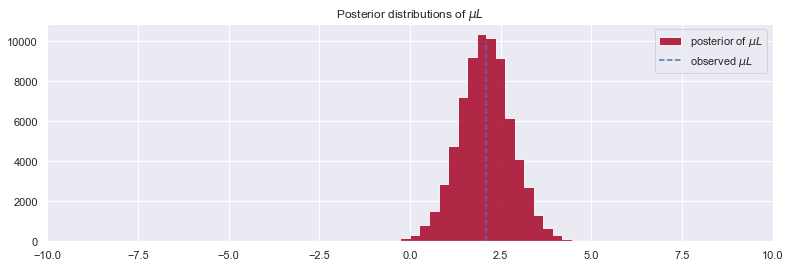

In [76]:
figsize(13, 4)

#histogram of posteriors
plt.hist(mu_L_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label=r'posterior of $\mu L$', color='#A60628')
plt.vlines(avg_diff_L, 0, 10000, linestyle='--', 
           label=r'observed $\mu L$')
plt.legend(loc='upper right')
plt.xlim(-10, 10)
plt.title(r'Posterior distributions of $\mu L$')

### Ticket 2: 
#### Lineups w/ 2+ Ballhandlers (Iso+PnR) 
#### vs. 
#### Lineups w/ 0 Ballhandlers (Iso+PnR)

In [68]:
A_cond = lineup_df_100[2] > 1
B_cond = lineup_df_100[2] == 0

In [69]:
lineups_A = lineup_df_100[A_cond]['adj_diff_to_league_avg'].values
lineups_B = lineup_df_100[B_cond]['adj_diff_to_league_avg'].values
len(lineups_A), len(lineups_B)

(285, 681)

In [70]:
trace, avg_diff_A, avg_diff_B = compare_lineup_efficiency(lineups_A, 
                                                          lineups_B)

Mean | A: 2.30; B: -0.52
Variance | A: 45.26; B: 44.84


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [var_B]
>Metropolis: [var_A]
>Metropolis: [mu_B]
>Metropolis: [mu_A]
Sampling 4 chains, 0 divergences: 100%|█| 82000/82000 [00:27<00:00, 3026.93draws
The number of effective samples is smaller than 10% for some parameters.


In [71]:
burned_trace = trace[2000:]
mu_A_samples = burned_trace['mu_A']
mu_B_samples = burned_trace['mu_B']
delta_samples = burned_trace['delta']

(-10.0, 10.0)

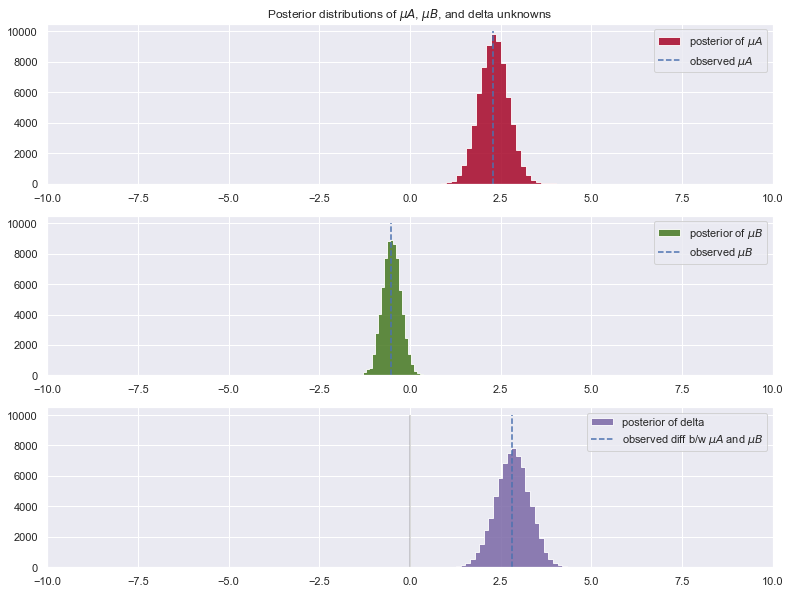

In [72]:
figsize(13, 10)

#histogram of posteriors

plt.subplot(3, 1, 1)
plt.hist(mu_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label=r'posterior of $\mu A$', color='#A60628')
plt.vlines(avg_diff_A, 0, 10000, linestyle='--', 
           label=r'observed $\mu A$')
plt.legend(loc='upper right')
plt.xlim(-10, 10)
plt.title(r'Posterior distributions of $\mu A$, $\mu B$, and delta unknowns')

plt.subplot(3, 1, 2)
plt.hist(mu_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label=r'posterior of $\mu B$', color='#467821')
plt.vlines(avg_diff_B, 0, 10000, linestyle='--', 
           label=r'observed $\mu B$')
plt.legend(loc='upper right')
plt.xlim(-10, 10)

plt.subplot(3, 1, 3)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label=r'posterior of delta', color='#7A68A6')
plt.vlines(avg_diff_A - avg_diff_B, 0, 10000, linestyle='--',
           label=r'observed diff b/w $\mu A$ and $\mu B$')
plt.vlines(0, 0, 10000, color='black', alpha=0.2)
plt.legend(loc='upper right');
plt.xlim(-10, 10)

### Ticket 3: 
#### Lineups w/ 2 Ballhandlers (PnR) + 0 Ballhandlers (Iso+PnR)
#### vs. 
#### Lineups w/ 1 Ballhandlers (PnR) + 1 Ballhandlers (Iso+PnR)

In [73]:
A_cond = (lineup_df_100[1] == 2) & (lineup_df_100[2] == 0)
B_cond = (lineup_df_100[1] == 1) & (lineup_df_100[2] == 1)

In [74]:
lineups_A = lineup_df_100[A_cond]['adj_diff_to_league_avg'].values
lineups_B = lineup_df_100[B_cond]['adj_diff_to_league_avg'].values
len(lineups_A), len(lineups_B)

(296, 265)

In [75]:
trace, avg_diff_A, avg_diff_B = compare_lineup_efficiency(lineups_A, 
                                                          lineups_B)

Mean | A: -0.23; B: 1.51
Variance | A: 47.31; B: 41.31


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [var_B]
>Metropolis: [var_A]
>Metropolis: [mu_B]
>Metropolis: [mu_A]
Sampling 4 chains, 0 divergences: 100%|█| 82000/82000 [00:41<00:00, 1994.99draws
The number of effective samples is smaller than 10% for some parameters.


In [76]:
burned_trace = trace[2000:]
mu_A_samples = burned_trace['mu_A']
mu_B_samples = burned_trace['mu_B']
delta_samples = burned_trace['delta']

(-10.0, 10.0)

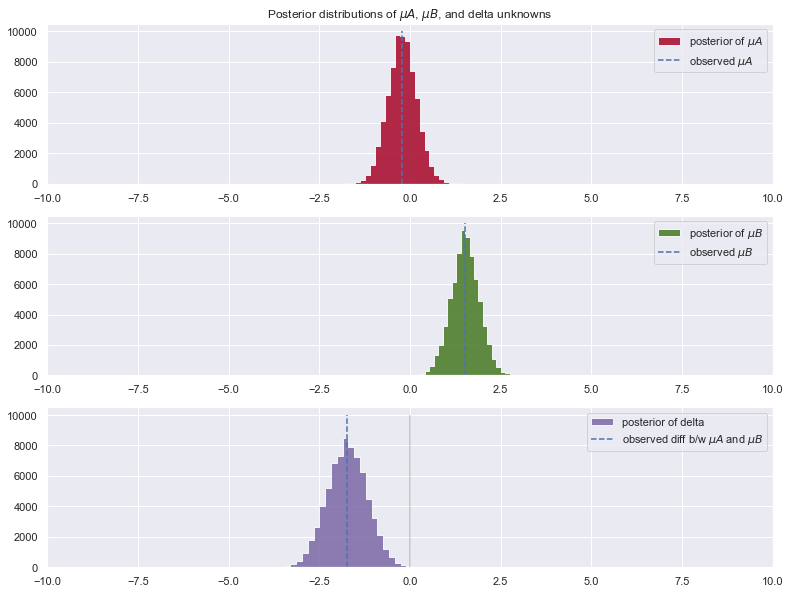

In [77]:
figsize(13, 10)

#histogram of posteriors

plt.subplot(3, 1, 1)
plt.hist(mu_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label=r'posterior of $\mu A$', color='#A60628')
plt.vlines(avg_diff_A, 0, 10000, linestyle='--', 
           label=r'observed $\mu A$')
plt.legend(loc='upper right')
plt.xlim(-10, 10)
plt.title(r'Posterior distributions of $\mu A$, $\mu B$, and delta unknowns')

plt.subplot(3, 1, 2)
plt.hist(mu_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label=r'posterior of $\mu B$', color='#467821')
plt.vlines(avg_diff_B, 0, 10000, linestyle='--', 
           label=r'observed $\mu B$')
plt.legend(loc='upper right')
plt.xlim(-10, 10)

plt.subplot(3, 1, 3)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label=r'posterior of delta', color='#7A68A6')
plt.vlines(avg_diff_A - avg_diff_B, 0, 10000, linestyle='--',
           label=r'observed diff b/w $\mu A$ and $\mu B$')
plt.vlines(0, 0, 10000, color='black', alpha=0.2)
plt.legend(loc='upper right');
plt.xlim(-10, 10)

### Ticket 4: 
#### Lineups w/ 1 Big (Post Up+Roll) & 0 Big (Roll+Cut)
#### vs. 
#### Lineups w/ 0 Big (Post Up+Roll) & 1 Big (Roll+Cut)

In [78]:
A_cond = (lineup_df_100[6] == 1) & (lineup_df_100[5] == 0) 
B_cond = (lineup_df_100[5] == 1) & (lineup_df_100[6] == 0) 

In [79]:
lineups_A = lineup_df_100[A_cond]['adj_diff_to_league_avg'].values
lineups_B = lineup_df_100[B_cond]['adj_diff_to_league_avg'].values
len(lineups_A), len(lineups_B)

(477, 566)

In [80]:
trace, avg_diff_A, avg_diff_B = compare_lineup_efficiency(lineups_A, 
                                                          lineups_B)

Mean | A: 1.05; B: 0.93
Variance | A: 45.88; B: 44.69


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [var_B]
>Metropolis: [var_A]
>Metropolis: [mu_B]
>Metropolis: [mu_A]
Sampling 4 chains, 0 divergences: 100%|█| 82000/82000 [00:30<00:00, 2669.22draws
The number of effective samples is smaller than 10% for some parameters.


In [81]:
burned_trace = trace[2000:]
mu_A_samples = burned_trace['mu_A']
mu_B_samples = burned_trace['mu_B']
delta_samples = burned_trace['delta']

(-10.0, 10.0)

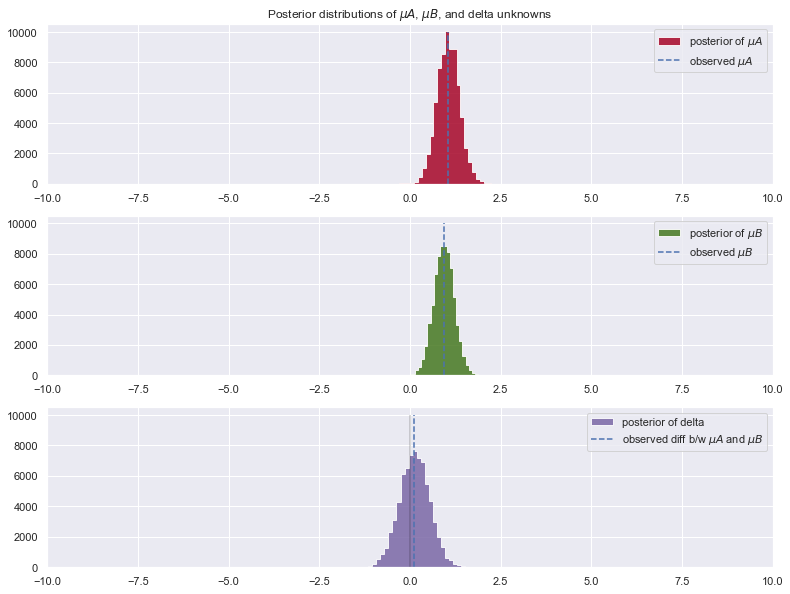

In [82]:
figsize(13, 10)

#histogram of posteriors

plt.subplot(3, 1, 1)
plt.hist(mu_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label=r'posterior of $\mu A$', color='#A60628')
plt.vlines(avg_diff_A, 0, 10000, linestyle='--', 
           label=r'observed $\mu A$')
plt.legend(loc='upper right')
plt.xlim(-10, 10)
plt.title(r'Posterior distributions of $\mu A$, $\mu B$, and delta unknowns')

plt.subplot(3, 1, 2)
plt.hist(mu_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label=r'posterior of $\mu B$', color='#467821')
plt.vlines(avg_diff_B, 0, 10000, linestyle='--', 
           label=r'observed $\mu B$')
plt.legend(loc='upper right')
plt.xlim(-10, 10)

plt.subplot(3, 1, 3)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label=r'posterior of delta', color='#7A68A6')
plt.vlines(avg_diff_A - avg_diff_B, 0, 10000, linestyle='--',
           label=r'observed diff b/w $\mu A$ and $\mu B$')
plt.vlines(0, 0, 10000, color='black', alpha=0.2)
plt.legend(loc='upper right');
plt.xlim(-10, 10)

### Ticket 5: 
#### Lineups w/ 2+ Wing (Off Screen)
#### vs. 
#### Lineups w/ 1- Wing (Off Screen)

In [83]:
A_cond = lineup_df_100[0] > 1 
B_cond = ~A_cond

In [84]:
lineups_A = lineup_df_100[A_cond]['adj_diff_to_league_avg'].values
lineups_B = lineup_df_100[B_cond]['adj_diff_to_league_avg'].values
len(lineups_A), len(lineups_B)

(139, 1382)

In [85]:
trace, avg_diff_A, avg_diff_B = compare_lineup_efficiency(lineups_A, 
                                                          lineups_B)

Mean | A: 1.37; B: 0.73
Variance | A: 43.03; B: 46.29


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [var_B]
>Metropolis: [var_A]
>Metropolis: [mu_B]
>Metropolis: [mu_A]
Sampling 4 chains, 0 divergences: 100%|█| 82000/82000 [00:46<00:00, 1781.41draws
The number of effective samples is smaller than 10% for some parameters.


In [86]:
burned_trace = trace[2000:]
mu_A_samples = burned_trace['mu_A']
mu_B_samples = burned_trace['mu_B']
delta_samples = burned_trace['delta']

(-10.0, 10.0)

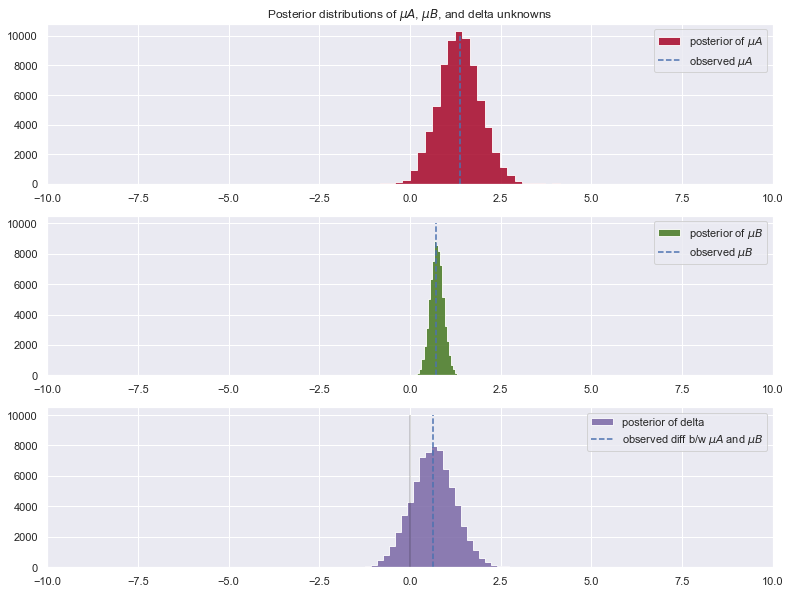

In [87]:
figsize(13, 10)

#histogram of posteriors

plt.subplot(3, 1, 1)
plt.hist(mu_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label=r'posterior of $\mu A$', color='#A60628')
plt.vlines(avg_diff_A, 0, 10000, linestyle='--', 
           label=r'observed $\mu A$')
plt.legend(loc='upper right')
plt.xlim(-10, 10)
plt.title(r'Posterior distributions of $\mu A$, $\mu B$, and delta unknowns')

plt.subplot(3, 1, 2)
plt.hist(mu_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label=r'posterior of $\mu B$', color='#467821')
plt.vlines(avg_diff_B, 0, 10000, linestyle='--', 
           label=r'observed $\mu B$')
plt.legend(loc='upper right')
plt.xlim(-10, 10)

plt.subplot(3, 1, 3)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label=r'posterior of delta', color='#7A68A6')
plt.vlines(avg_diff_A - avg_diff_B, 0, 10000, linestyle='--',
           label=r'observed diff b/w $\mu A$ and $\mu B$')
plt.vlines(0, 0, 10000, color='black', alpha=0.2)
plt.legend(loc='upper right');
plt.xlim(-10, 10)

### Ticket 6: 
#### Lineups w/ Nikola Jokic
#### vs. 
#### Lineups w/ Similar Configurations

In [90]:
team_cluster_lookup(2021, 'Denver Nuggets')

,season,team,player_cluster,player_alt
1613,2021,Denver Nuggets,6,nikolajokic
1614,2021,Denver Nuggets,3,willbarton
1615,2021,Denver Nuggets,6,aarongordon
1616,2021,Denver Nuggets,1,montemorris
1617,2021,Denver Nuggets,1,nahshonhyland
1618,2021,Denver Nuggets,3,jeffgreen
1619,2021,Denver Nuggets,3,jamychalgreen
1620,2021,Denver Nuggets,2,austinrivers
1621,2021,Denver Nuggets,1,facundocampazzo
1622,2021,Denver Nuggets,6,demarcuscousins


In [91]:
player = 'Nikola Jokic'
season = 2021
cluster = 6

In [92]:
A_query, B_query = generate_player_queries(player, season, cluster)
season_cond = lineup_df_100['season'] == season
cluster_cond = lineup_df_100[cluster] > 0

In [93]:
lineups_A = lineup_df_100[season_cond & cluster_cond].query(A_query)\
            ['adj_diff_to_league_avg'].values
lineups_B = lineup_df_100[season_cond & cluster_cond].query(B_query)\
            ['adj_diff_to_league_avg'].values
len(lineups_A), len(lineups_B)

(7, 105)

In [94]:
lineup_df_100[season_cond & cluster_cond].query(A_query)\
[positions + ['Poss', 'adj_diff_to_league_avg']]

,PG,SG,SF,PF,C,Poss,adj_diff_to_league_avg
384,Monte Morris,Will Barton,Aaron Gordon,Jeff Green,Nikola Jokic,1563,10.644611
385,Monte Morris,Will Barton,Michael Porter,Aaron Gordon,Nikola Jokic,355,-6.355389
386,Monte Morris,Austin Rivers,Aaron Gordon,Jeff Green,Nikola Jokic,309,11.344611
387,Monte Morris,Austin Rivers,Will Barton,Aaron Gordon,Nikola Jokic,249,8.881176
389,Nah'Shon Hyland,Will Barton,Aaron Gordon,Jeff Green,Nikola Jokic,169,-0.242879
391,Monte Morris,Nah'Shon Hyland,Will Barton,Aaron Gordon,Nikola Jokic,137,11.595298
392,Monte Morris,Will Barton,Aaron Gordon,JaMychal Green,Nikola Jokic,116,-4.031783


In [95]:
trace, avg_diff_A, avg_diff_B = compare_lineup_efficiency(lineups_A, 
                                                          lineups_B)

Mean | A: 4.55; B: 1.06
Variance | A: 52.46; B: 38.56


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [var_B]
>Metropolis: [var_A]
>Metropolis: [mu_B]
>Metropolis: [mu_A]
Sampling 4 chains, 0 divergences: 100%|█| 82000/82000 [00:21<00:00, 3873.17draws
The number of effective samples is smaller than 10% for some parameters.


In [96]:
burned_trace = trace[2000:]
mu_A_samples = burned_trace['mu_A']
mu_B_samples = burned_trace['mu_B']
delta_samples = burned_trace['delta']

(-10.0, 10.0)

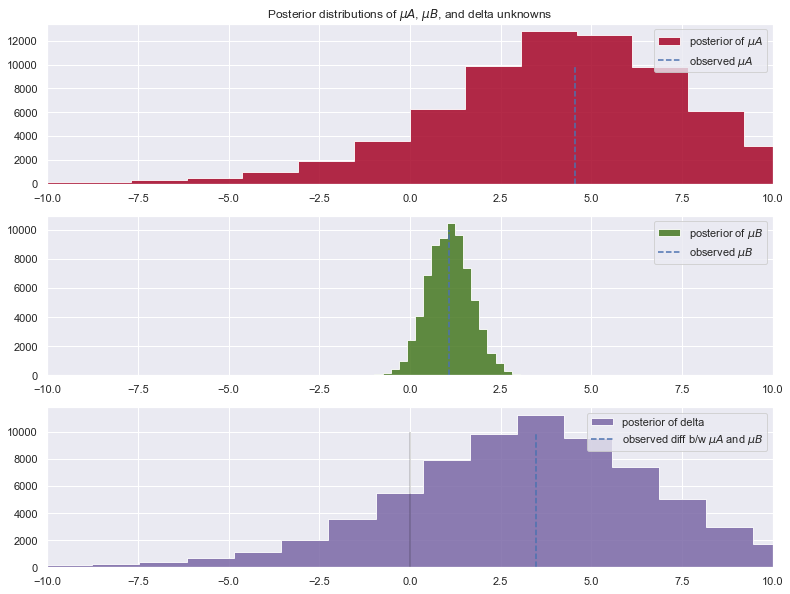

In [97]:
figsize(13, 10)

#histogram of posteriors

plt.subplot(3, 1, 1)
plt.hist(mu_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label=r'posterior of $\mu A$', color='#A60628')
plt.vlines(avg_diff_A, 0, 10000, linestyle='--', 
           label=r'observed $\mu A$')
plt.legend(loc='upper right')
plt.xlim(-10, 10)
plt.title(r'Posterior distributions of $\mu A$, $\mu B$, and delta unknowns')

plt.subplot(3, 1, 2)
plt.hist(mu_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label=r'posterior of $\mu B$', color='#467821')
plt.vlines(avg_diff_B, 0, 10000, linestyle='--', 
           label=r'observed $\mu B$')
plt.legend(loc='upper right')
plt.xlim(-10, 10)

plt.subplot(3, 1, 3)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label=r'posterior of delta', color='#7A68A6')
plt.vlines(avg_diff_A - avg_diff_B, 0, 10000, linestyle='--',
           label=r'observed diff b/w $\mu A$ and $\mu B$')
plt.vlines(0, 0, 10000, color='black', alpha=0.2)
plt.legend(loc='upper right');
plt.xlim(-10, 10)

### Ticket 7: 
#### Lineups w/ Russell Westbook
#### vs. 
#### Lineups w/ Similar Configurations

In [98]:
team_cluster_lookup(2021, 'Los Angeles Lakers')

,season,team,player_cluster,player_alt
1427,2021,Los Angeles Lakers,2,russellwestbrook
1428,2021,Los Angeles Lakers,2,lebronjames
1429,2021,Los Angeles Lakers,3,malikmonk
1430,2021,Los Angeles Lakers,6,anthonydavis
1431,2021,Los Angeles Lakers,6,carmeloanthony
1432,2021,Los Angeles Lakers,1,talenhorton-tucker
1433,2021,Los Angeles Lakers,3,austinreaves
1434,2021,Los Angeles Lakers,3,averybradley
1435,2021,Los Angeles Lakers,5,dwighthoward
1436,2021,Los Angeles Lakers,3,stanleyjohnson


In [99]:
player = 'Russell Westbrook'
season = 2021
cluster = 2

In [100]:
A_query, B_query = generate_player_queries(player, season, cluster)
season_cond = lineup_df_100['season'] == season
cluster_cond = lineup_df_100[cluster] > 0

In [101]:
lineups_A = lineup_df_100[season_cond & cluster_cond].query(A_query)\
            ['adj_diff_to_league_avg'].values
lineups_B = lineup_df_100[season_cond & cluster_cond].query(B_query)\
            ['adj_diff_to_league_avg'].values
len(lineups_A), len(lineups_B)

(7, 190)

In [102]:
lineup_df_100[season_cond & cluster_cond].query(A_query)\
[positions + ['Poss', 'adj_diff_to_league_avg']]

,PG,SG,SF,PF,C,Poss,adj_diff_to_league_avg
689,Russell Westbrook,Malik Monk,Avery Bradley,Stanley Johnson,LeBron James,190,6.928690
690,Russell Westbrook,Malik Monk,Austin Reaves,Stanley Johnson,LeBron James,160,2.307379
691,Russell Westbrook,Malik Monk,Avery Bradley,Carmelo Anthony,Anthony Davis,145,-4.161611
692,Russell Westbrook,Malik Monk,Austin Reaves,Carmelo Anthony,LeBron James,134,0.891131
693,Russell Westbrook,Avery Bradley,Talen Horton-Tucker,Carmelo Anthony,Anthony Davis,114,-1.058855
694,Russell Westbrook,Malik Monk,Avery Bradley,Stanley Johnson,Anthony Davis,113,-4.680788
696,Russell Westbrook,Kent Bazemore,LeBron James,Anthony Davis,DeAndre Jordan,104,-5.728848


In [103]:
trace, avg_diff_A, avg_diff_B = compare_lineup_efficiency(lineups_A, 
                                                          lineups_B)

Mean | A: -0.79; B: 1.09
Variance | A: 17.57; B: 52.64


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [var_B]
>Metropolis: [var_A]
>Metropolis: [mu_B]
>Metropolis: [mu_A]
Sampling 4 chains, 0 divergences: 100%|█| 82000/82000 [00:20<00:00, 3920.88draws
The number of effective samples is smaller than 10% for some parameters.


In [104]:
burned_trace = trace[2000:]
mu_A_samples = burned_trace['mu_A']
mu_B_samples = burned_trace['mu_B']
delta_samples = burned_trace['delta']

(-10.0, 10.0)

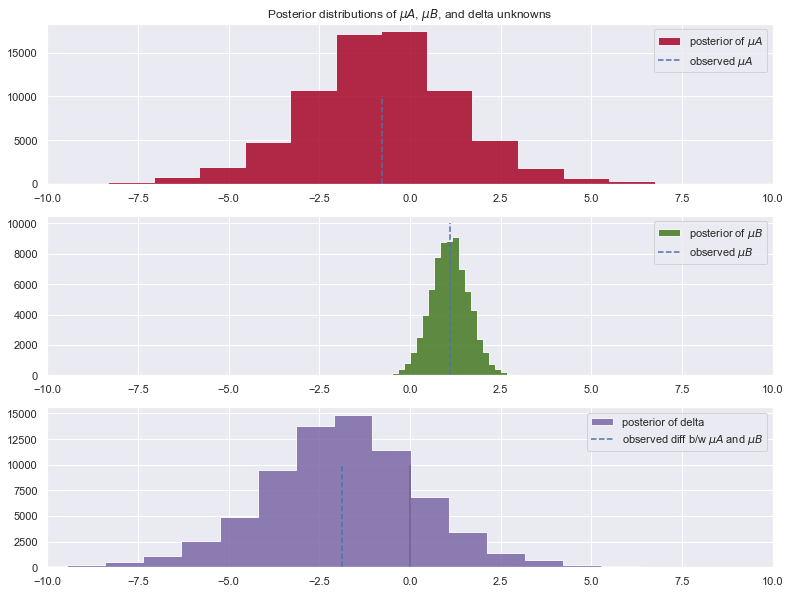

In [105]:
figsize(13, 10)

#histogram of posteriors

plt.subplot(3, 1, 1)
plt.hist(mu_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label=r'posterior of $\mu A$', color='#A60628')
plt.vlines(avg_diff_A, 0, 10000, linestyle='--', 
           label=r'observed $\mu A$')
plt.legend(loc='upper right')
plt.xlim(-10, 10)
plt.title(r'Posterior distributions of $\mu A$, $\mu B$, and delta unknowns')

plt.subplot(3, 1, 2)
plt.hist(mu_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label=r'posterior of $\mu B$', color='#467821')
plt.vlines(avg_diff_B, 0, 10000, linestyle='--', 
           label=r'observed $\mu B$')
plt.legend(loc='upper right')
plt.xlim(-10, 10)

plt.subplot(3, 1, 3)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label=r'posterior of delta', color='#7A68A6')
plt.vlines(avg_diff_A - avg_diff_B, 0, 10000, linestyle='--',
           label=r'observed diff b/w $\mu A$ and $\mu B$')
plt.vlines(0, 0, 10000, color='black', alpha=0.2)
plt.legend(loc='upper right');
plt.xlim(-10, 10)